In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [2]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import NGram
from pyspark.sql.functions import udf
from pyspark.ml.feature import StopWordsRemover

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline, PipelineModel

In [3]:
review_raw = spark.read.json("review.json")

### Check the distribution of rating stars

In [5]:
print review_raw.groupBy(review_raw["stars"]).count().show()

+-----+-------+
|stars|  count|
+-----+-------+
|    5|1988003|
|    1| 639849|
|    3| 570819|
|    2| 402396|
|    4|1135830|
+-----+-------+

None


In [7]:
# Exclude neutral reviews:
def pos_neg(star):
    if star <3:
        return 0 #negative
    elif star >3 :
        return 1 #positive
    else:
        return 2 #neutral
    
star_to_senti = udf(lambda x:pos_neg(x))
train_test_DF = review_raw.select('text',star_to_senti('stars').alias('label')).filter("label != 2")

### Create TFIDF Feature

In [37]:
#remove punctuation
import re
import string

def remove_num_punct(text):

    my_string = text.replace("-", " ")
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", my_string)  # delete stuff but leave at least a space to avoid clumping together

    nopunct = nopunct.split()
    #nopunct = [stemmer.stem(w).strip(" ") for w in nopunct] #remove stop word and normalize word using stemmer.
    nopunct = [w.strip() for w in nopunct]
    nopunct = ' '.join(nopunct)
    
    return nopunct

udf_num_punct = udf(lambda x:remove_num_punct(x))
review_rmsw = train_test_DF.select(udf_num_punct('text').alias('text'), 'label')

NameError: name 'train_test_DF' is not defined

In [9]:
### setNumFeatures
n_features = 100

### Get a subset of data

In [11]:
try_DF = review_rmsw.sample(False, 0.05, 1)

### Split train and test

In [16]:
train_set.unpersist()
test_set.unpersist()

DataFrame[text: string, label: string]

In [17]:
train_set, test_set= try_DF.randomSplit([0.8, 0.2])
train_set = train_set.withColumn("label", train_set["label"].cast(DoubleType()))
test_set = test_set.withColumn("label", test_set["label"].cast(DoubleType()))
train_set.cache()
test_set.cache()

DataFrame[text: string, label: double]

### Define evaluation metrics

In [14]:
# compute accuracy on the test set 
def evaluate_metric(predictions):
    
    evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderROC")
    AUC = evaluator.evaluate(predictions)
    print("Area under ROC curve = %0.4f" %(AUC))
    
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="f1")
    f1 = evaluator.evaluate(predictions)
    print("F1_score = %0.4f" %(f1))

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Accuracy = %0.4f" %(accuracy))

### Model 1: Logistic Regression

In [18]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered", caseSensitive=False)
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
lr = LogisticRegression(maxIter=100, regParam=0.01, elasticNetParam=0.8)
pipeline_lr=Pipeline(stages=[tokenizer,remover,hashingTF,idf, lr])

In [29]:
%%time
logreg_model=pipeline_lr.fit(train_set)
log_pred = logreg_model.transform(test_set)

CPU times: user 195 ms, sys: 85 ms, total: 280 ms
Wall time: 36.4 s


In [23]:
evaluate_metric(log_pred)

Area under ROC curve = 0.9603
F1_score = 0.8929
Accuracy = 0.8994


In [31]:
log_pred.groupBy(log_pred["label"], log_pred["prediction"]).count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|30848|
|  0.0|       1.0| 3685|
|  1.0|       0.0|  523|
|  0.0|       0.0| 6775|
+-----+----------+-----+



### Model 2: Unigram Naive Bayes

In [25]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered", caseSensitive=False)
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
nb = NaiveBayes(smoothing = 1.0, modelType = "multinomial")
pipeline_nb=Pipeline(stages=[tokenizer,remover,hashingTF,idf, nb])

In [26]:
%%time
nb_model=pipeline_nb.fit(train_set)
nb_pred = nb_model.transform(test_set)

CPU times: user 42.6 ms, sys: 11.1 ms, total: 53.7 ms
Wall time: 7.8 s


In [28]:
evaluate_metric(nb_pred)

Area under ROC curve = 0.6110
F1_score = 0.8799
Accuracy = 0.8773


In [33]:
nb_pred.groupBy(nb_pred["label"], nb_pred["prediction"]).count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|28060|
|  0.0|       1.0| 1820|
|  1.0|       0.0| 3311|
|  0.0|       0.0| 8640|
+-----+----------+-----+



In [36]:
nb_pred.select('probability','prediction').show(truncate=False)

+------------------------------------------+----------+
|probability                               |prediction|
+------------------------------------------+----------+
|[1.0,2.233587851788781E-226]              |0.0       |
|[0.9992616979015009,7.38302098499225E-4]  |0.0       |
|[9.842443476377716E-29,1.0]               |1.0       |
|[2.499656474851975E-32,1.0]               |1.0       |
|[0.9999932253023083,6.77469769168618E-6]  |0.0       |
|[1.8852443832876588E-31,1.0]              |1.0       |
|[6.897843818067181E-31,1.0]               |1.0       |
|[4.744868603502499E-62,1.0]               |1.0       |
|[0.9999999999912947,8.70520844385707E-12] |0.0       |
|[1.0,1.2309625281567158E-63]              |0.0       |
|[2.719911853042468E-10,0.9999999997280089]|1.0       |
|[1.8574049202457505E-33,1.0]              |1.0       |
|[9.878116655662891E-179,1.0]              |1.0       |
|[0.9999999985943355,1.405664575753711E-9] |0.0       |
|[8.09819074332604E-65,1.0]                |1.0 

In [37]:
log_pred.select('probability','prediction').show(truncate=False)

+------------------------------------------+----------+
|probability                               |prediction|
+------------------------------------------+----------+
|[0.7344657012508554,0.2655342987491446]   |0.0       |
|[0.5177869283272799,0.48221307167272015]  |0.0       |
|[0.09716840083293621,0.9028315991670638]  |1.0       |
|[0.07071973741654106,0.929280262583459]   |1.0       |
|[0.0035489188778829142,0.9964510811221171]|1.0       |
|[0.16878815939278374,0.8312118406072163]  |1.0       |
|[0.3337479990318102,0.6662520009681898]   |1.0       |
|[0.040811858785711676,0.9591881412142883] |1.0       |
|[0.0689082188648282,0.9310917811351719]   |1.0       |
|[0.8838626807099722,0.11613731929002782]  |0.0       |
|[0.01002157352963042,0.9899784264703695]  |1.0       |
|[0.0018733713046665467,0.9981266286953334]|1.0       |
|[4.6633692869421005E-4,0.9995336630713059]|1.0       |
|[0.27315307894836377,0.7268469210516362]  |1.0       |
|[0.08761666275441887,0.9123833372455811]  |1.0 

## -------------------------------
## Spark Query - 
#### Looking at a single business - what words are most commonly used to describe this restuarant?

In [3]:
biz_raw = spark.read.json("business.json")
review_raw = spark.read.json("review.json")

In [4]:
# select the restaurants with the most number of reviews, seems that they are all from LV - high class buffet
biz_raw.sort('review_count',ascending = False).select('name','review_count','city').show(truncate=False)

+--------------------------------+------------+---------+
|name                            |review_count|city     |
+--------------------------------+------------+---------+
|Mon Ami Gabi                    |6979        |Las Vegas|
|Bacchanal Buffet                |6417        |Las Vegas|
|Wicked Spoon                    |5632        |Las Vegas|
|Gordon Ramsay BurGR             |5429        |Las Vegas|
|Earl of Sandwich                |4789        |Las Vegas|
|Hash House A Go Go              |4371        |Las Vegas|
|Serendipity 3                   |3913        |Las Vegas|
|The Buffet                      |3873        |Las Vegas|
|Lotus of Siam                   |3838        |Las Vegas|
|The Buffet at Bellagio          |3700        |Las Vegas|
|ARIA Resort & Casino            |3634        |Las Vegas|
|The Cosmopolitan of Las Vegas   |3621        |Las Vegas|
|Secret Pizza                    |3542        |Las Vegas|
|Bouchon at the Venezia Tower    |3439        |Las Vegas|
|Luxor Hotel a

In [5]:
# select a business, 'Wicked Spoon', and look for its business_id
biz_raw.filter("name like '%Wicked Spoon%'").select('business_id').show(truncate=False)

+----------------------+
|business_id           |
+----------------------+
|K7lWdNUhCbcnEvI0NhGewg|
+----------------------+



In [5]:
# filter out the reviews of this restaurant
biz = review_raw.filter("business_id like '%K7lWdNUhCbcnEvI0NhGewg%'")

In [6]:
# Exclude neutral reviews:
def pos_neg(star):
    if star <3:
        return 0 #negative
    elif star >3 :
        return 1 #positive
    else:
        return 2 #neutral
    
star_to_senti = udf(lambda x:pos_neg(x))
full_DF = review_raw.select('text',star_to_senti('stars').alias('label')).filter("label != 2")

In [7]:
#remove punctuation
import re
import string

def remove_num_punct(text):

    my_string = text.replace("-", " ")
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", my_string)  # delete stuff but leave at least a space to avoid clumping together

    nopunct = nopunct.split()
    #nopunct = [stemmer.stem(w).strip(" ") for w in nopunct] #remove stop word and normalize word using stemmer.
    nopunct = [w.strip() for w in nopunct]
    nopunct = ' '.join(nopunct)
    
    return nopunct

In [8]:
udf_num_punct = udf(lambda x:remove_num_punct(x))
review_words = full_DF.select(udf_num_punct('text').alias('words'))
tokenizer = Tokenizer(inputCol="words", outputCol="tokenized")
review_words1 = tokenizer.transform(review_words)
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered", caseSensitive=False)
review_words2 = remover.transform(review_words1)
biz_list = [item for sublist in review_words2.select('filtered').collect() for item in sublist.filtered]
biz_list


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 52182)


Traceback (most recent call last):
  File "/Users/yandixin_929/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/yandixin_929/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/Users/yandixin_929/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/yandixin_929/anaconda/lib/python2.7/SocketServer.py", line 655, in __init__
    self.handle()
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/serializers.py", line 577, in read_int
    raise EOFError
EOFError
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52142)
Traceback (mo

----------------------------------------


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:52142)

In [ ]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
#text = open('alice.txt').read()
text = " ".join(biz_list) #read in review text

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open("tree5.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white",width=2000, height=1000,  max_words=2000, mask=alice_mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(text)

# store to file
wc.to_file("alice.png")

# show
plt.figure(figsize=(20, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20, 15))
plt.axis("off")
plt.show()

## --------------------------------------

In [ ]:
from collections import Counter
ctr = Counter(biz_list)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud()
wordcloud.fit_words(ctr)

fig=plt.figure(figsize=(12, 10))   # Prepare a plot 5x3 inches
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [67]:
#subset_DF = full_DF.sample(False, 0.05, 1)

In [69]:
pos = subset_DF.filter('label = 1').select('text')
neg = subset_DF.filter('label = 0').select('text')

In [71]:
#remove punctuation
import re
import string

def remove_num_punct(text):

    my_string = text.replace("-", " ")
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", my_string)  # delete stuff but leave at least a space to avoid clumping together

    nopunct = nopunct.split()
    #nopunct = [stemmer.stem(w).strip(" ") for w in nopunct] #remove stop word and normalize word using stemmer.
    nopunct = [w.strip() for w in nopunct]
    nopunct = ' '.join(nopunct)
    
    return nopunct




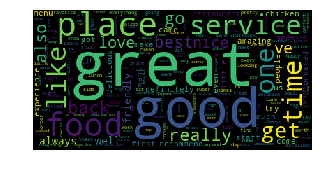

In [72]:
udf_num_punct = udf(lambda x:remove_num_punct(x))
review_words = pos.select(udf_num_punct('text').alias('words'))
tokenizer = Tokenizer(inputCol="words", outputCol="tokenized")
review_words1 = tokenizer.transform(review_words)
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered", caseSensitive=False)
review_words2 = remover.transform(review_words1)
biz_list = [item for sublist in review_words2.select('filtered').collect() for item in sublist.filtered]

from collections import Counter
ctr = Counter(biz_list)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud()
wordcloud.fit_words(ctr)

fig=plt.figure(figsize=(5, 3))   # Prepare a plot 5x3 inches
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

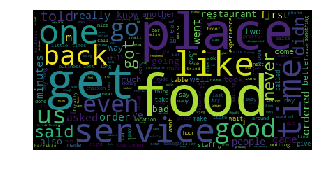

In [73]:
udf_num_punct = udf(lambda x:remove_num_punct(x))
review_words = neg.select(udf_num_punct('text').alias('words'))
tokenizer = Tokenizer(inputCol="words", outputCol="tokenized")
review_words1 = tokenizer.transform(review_words)
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered", caseSensitive=False)
review_words2 = remover.transform(review_words1)
biz_list = [item for sublist in review_words2.select('filtered').collect() for item in sublist.filtered]

from collections import Counter
ctr = Counter(biz_list)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud()
wordcloud.fit_words(ctr)

fig=plt.figure(figsize=(5, 3))   # Prepare a plot 5x3 inches
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [61]:
tokenizer = Tokenizer(inputCol="words", outputCol="tokenized")
review_words1 = tokenizer.transform(review_words)
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered", caseSensitive=False)
review_words2 = remover.transform(review_words1)
review_words2.show()

+--------------------+--------------------+--------------------+
|               words|           tokenized|            filtered|
+--------------------+--------------------+--------------------+
|One of the better...|[one, of, the, be...|[one, better, buf...|
|gourmet normal fo...|[gourmet, normal,...|[gourmet, normal,...|
|In terms of buffe...|[in, terms, of, b...|[terms, buffets, ...|
|I would definitel...|[i, would, defini...|[definitely, come...|
|The most amazing ...|[the, most, amazi...|[amazing, buffet,...|
|I dont frequent b...|[i, dont, frequen...|[dont, frequent, ...|
|By far one of the...|[by, far, one, of...|[far, one, amazin...|
|stars This is my ...|[stars, this, is,...|[stars, new, favo...|
|In my opinion thi...|[in, my, opinion,...|[opinion, best, b...|
|Exhausted after a...|[exhausted, after...|[exhausted, long,...|
|Large groups requ...|[large, groups, r...|[large, groups, r...|
|My Hubby and I we...|[my, hubby, and, ...|[hubby, went, wic...|
|Was a fan before ...|[wa

In [64]:
biz_list = [item for sublist in review_words2.select('filtered').collect() for item in sublist.filtered]
biz_list

[u'one',
 u'better',
 u'buffets',
 u'vegas',
 u'almost',
 u'dinner',
 u'carefully',
 u'prepared',
 u'foods',
 u'pleasing',
 u'eyes',
 u'nose',
 u'tongue',
 u'get',
 u'gelato',
 u'various',
 u'flavors',
 u'smoked',
 u'salmon',
 u'slices',
 u'minus',
 u'one',
 u'star',
 u'disgusted',
 u'spilled',
 u'beer',
 u'register',
 u'counter',
 u'ground',
 u'rested',
 u'elbow',
 u'one',
 u'end',
 u'smell',
 u'beer',
 u'lingered',
 u'throughout',
 u'dinner',
 u'blegh',
 u'gourmet',
 u'normal',
 u'food',
 u'presentation',
 u'dishes',
 u'tapas',
 u'style',
 u'mini',
 u'pots',
 u'pans',
 u'containing',
 u'expertly',
 u'crafted',
 u'dishes',
 u'used',
 u'mushroom',
 u'cooked',
 u'reduced',
 u'wine',
 u'sauce',
 u'favorite',
 u'dish',
 u'didn',
 u'see',
 u'time',
 u'hear',
 u'mac',
 u'cheese',
 u'amazing',
 u'havent',
 u'im',
 u'lactose',
 u'intolerant',
 u'slabs',
 u'bacon',
 u'really',
 u'long',
 u'sausage',
 u'never',
 u'fail',
 u'impress',
 u'say',
 u'favorite',
 u'things',
 u'place',
 u'desserts',
 

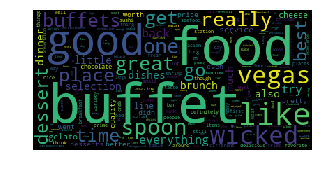

In [65]:
from collections import Counter
ctr = Counter(biz_list)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud()
wordcloud.fit_words(ctr)

fig=plt.figure(figsize=(5, 3))   # Prepare a plot 5x3 inches
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [12]:
biz_raw.select('city').groupBy('city').count().sort('count', ascending=False).show(truncate=False)

+-----------+-----+
|city       |count|
+-----------+-----+
|Las Vegas  |24768|
|Phoenix    |15656|
|Toronto    |15483|
|Charlotte  |7557 |
|Scottsdale |7510 |
|Pittsburgh |5688 |
|Montréal   |5175 |
|Mesa       |5146 |
|Henderson  |4130 |
|Tempe      |3949 |
|Chandler   |3649 |
|Edinburgh  |3625 |
|Cleveland  |2979 |
|Madison    |2891 |
|Glendale   |2841 |
|Gilbert    |2835 |
|Mississauga|2316 |
|Stuttgart  |1975 |
|Peoria     |1527 |
|Markham    |1390 |
+-----------+-----+
only showing top 20 rows



In [6]:
full_DF = review_raw.select('business_id', 'text','stars').join(id_name_DF,'business_id','inner')

In [8]:
full_DF.show()

+--------------------+--------------------+-----+--------------------+
|         business_id|                text|stars|                name|
+--------------------+--------------------+-----+--------------------+
|--9e1ONYQuAa-CB_R...|What can I say.. ...|    5|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|We went in with h...|    2|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|I want to give th...|    3|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|Went here for guy...|    5|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|One word my frien...|    5|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|We tried their Fr...|    3|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|I've never had a ...|    5|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|Truffle and Parm ...|    4|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|Located inside my...|    3|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|As far as steakho...|    4|Delmonico Steakhouse|
|--9e1ONYQuAa-CB_R...|After the most in...|    5|Delmonico Steakhouse|
|--9e1

In [9]:
full_DF.persist()

DataFrame[business_id: string, text: string, stars: bigint, name: string]

In [9]:
full_DF.count()

4324067